# Practice

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = tf.keras.layers.Dense(
    units=120,
    activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 190s 219ms/step - loss: 2.2579 - accuracy: 0.4343 - val_loss: 3.1575 - val_accuracy: 0.2317
Epoch 2/2
750/750 [==============================] - 156s 207ms/step - loss: 0.7248 - accuracy: 0.8048 - val_loss: 1.4184 - val_accuracy: 0.5963


In [11]:
import os

# cam_model_path = os.getenv('HOME') + '~/aiffel/class_activation_map/cam_model1.h5'
cam_model_path = './cam_model1.h5'

cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


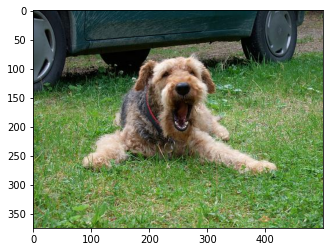

In [57]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [15]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [58]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

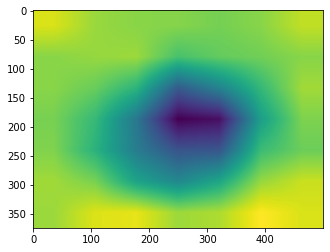

In [59]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [60]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

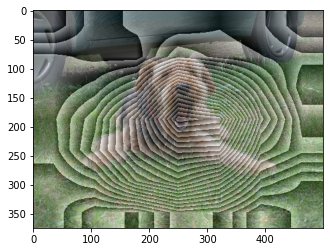

In [61]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

100


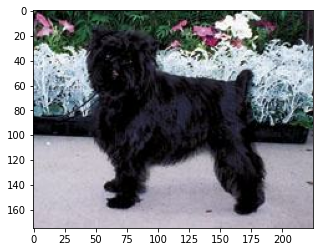

In [20]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [21]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

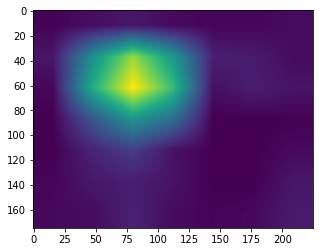

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

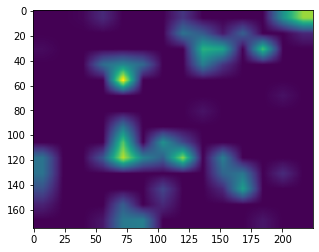

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

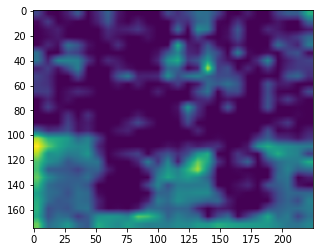

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

108


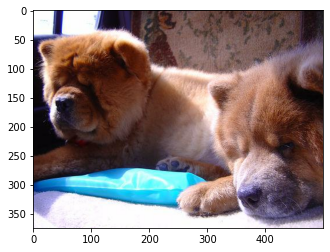

In [25]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

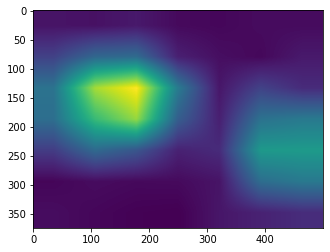

In [26]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [27]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [28]:
rect = get_bbox(cam_image)
rect

array([[-48, 301],
       [  6,  -3],
       [549,  94],
       [494, 399]])

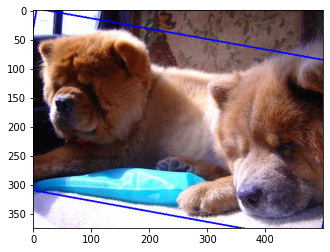

In [29]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [30]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [31]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.008, -0.096, 1.064, 1.098]

In [32]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [33]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [34]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.33257079997978584

# ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습
- 모델 구성(ResNet50 + GAP + DenseLayer)
- 모델 학습(충분한 에포크, 20이상?)
- 모델 학습 수렴하는지 확인
- 모델 정장
- CAM 시각화 후 원본이미지와 합성
- IOU 도출

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 모델 구성(ResNet50 + GAP + DenseLayer)

In [31]:
import os

# 저장할 파일 경로
CHECKPOINT_PATH = './cam_model2.h5'
BESTMODEL_PATH = './cam_best_model.h5'

# 저장된 체크포인트가 있으면 로드
if os.path.exists(CHECKPOINT_PATH):
    print("🔄 기존 모델 불러오는 중...")
    model = tf.keras.models.load_model(CHECKPOINT_PATH)
else:
    print("🆕 새로운 모델 생성 해야함")

🔄 기존 모델 불러오는 중...


In [18]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = tf.keras.layers.Dense(
    units=120,
    activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [4]:
# 이미지 전처리
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 모델 학습(충분한 에포크, 20이상?)

In [19]:
# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, save_best_only=False, save_weights_only=False
)

checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    BESTMODEL_PATH, save_best_only=True, save_weights_only=False
)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
750/750 [==============================] - 190s 239ms/step - loss: 2.2170 - accuracy: 0.4498 - val_loss: 3.1828 - val_accuracy: 0.2523


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 161s 215ms/step - loss: 0.7380 - accuracy: 0.7979 - val_loss: 1.0551 - val_accuracy: 0.6904
Epoch 3/20
750/750 [==============================] - 169s 225ms/step - loss: 0.2403 - accuracy: 0.9503 - val_loss: 0.9505 - val_accuracy: 0.7215
Epoch 4/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0702 - accuracy: 0.9927 - val_loss: 0.9192 - val_accuracy: 0.7330
Epoch 5/20
750/750 [==============================] - 163s 217ms/step - loss: 0.0317 - accuracy: 0.9979 - val_loss: 0.9361 - val_accuracy: 0.7334
Epoch 6/20
750/750 [==============================] - 165s 220ms/step - loss: 0.0181 - accuracy: 0.9994 - val_loss: 0.9175 - val_accuracy: 0.7466
Epoch 7/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0129 - accuracy: 0.9996 - val_loss: 0.9386 - val_accuracy: 0.7362
Epoch 8/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0103 - accuracy: 0.9998 - val_loss: 0.9485 -

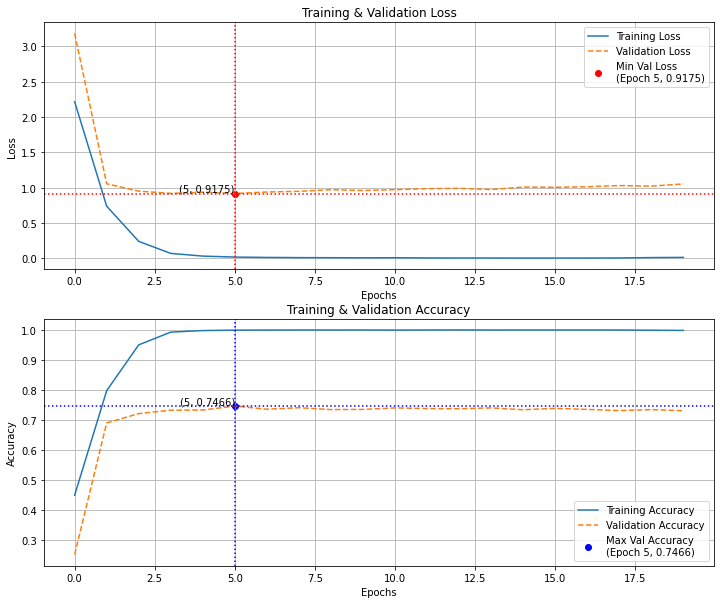

In [20]:
# ✅ 모델 훈련 후 history 객체 확인 필요
history = history_cam_model  # 모델 훈련 후 다시 할당 필요

# ✅ 손실 및 정확도 값 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# ✅ Validation 기준 최하점 (Loss) & 최고점 (Accuracy) 찾기
min_val_loss_epoch = np.argmin(val_loss)  # 최소 validation loss의 epoch
min_val_loss = val_loss[min_val_loss_epoch]

max_val_acc_epoch = np.argmax(val_acc)  # 최대 validation accuracy의 epoch
max_val_acc = val_acc[max_val_acc_epoch]

# ✅ 손실 (Loss) 그래프
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')

# 최소 validation loss 지점 표시
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
plt.text(min_val_loss_epoch, min_val_loss, f'({min_val_loss_epoch}, {min_val_loss:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
plt.axhline(min_val_loss, linestyle='dotted', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# ✅ 정확도 (Accuracy) 그래프
plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', linestyle='dashed')

# 최대 validation accuracy 지점 표시
plt.scatter(max_val_acc_epoch, max_val_acc, color='blue', label=f'Max Val Accuracy\n(Epoch {max_val_acc_epoch}, {max_val_acc:.4f})')
plt.text(max_val_acc_epoch, max_val_acc, f'({max_val_acc_epoch}, {max_val_acc:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(max_val_acc_epoch, linestyle='dotted', color='blue')
plt.axhline(max_val_acc, linestyle='dotted', color='blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

# ✅ 그래프 출력
plt.show()


### 모델 학습 수렴하는지 확인

In [ ]:
# 5에포크 이후 overfitting을 확인할 수 있다.

In [32]:
# Best 모델 다시 얻기
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = tf.keras.layers.Dense(
    units=120,
    activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, save_best_only=False, save_weights_only=False
)

checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    BESTMODEL_PATH, save_best_only=True, save_weights_only=False
)

# EarlyStopping 콜백 추가 (patience=3)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 데이터의 손실 기준
    patience=3,          # 개선되지 않는 epoch 수
    restore_best_weights=True,  # 가장 좋은 가중치 복원
    verbose=1
)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback2, early_stopping_callback]
)

Epoch 1/10
750/750 [==============================] - 165s 205ms/step - loss: 2.2110 - accuracy: 0.4482 - val_loss: 3.3064 - val_accuracy: 0.2208
Epoch 2/10
750/750 [==============================] - 166s 221ms/step - loss: 0.7618 - accuracy: 0.7866 - val_loss: 1.0901 - val_accuracy: 0.6784
Epoch 3/10
750/750 [==============================] - 173s 231ms/step - loss: 0.2330 - accuracy: 0.9497 - val_loss: 0.9598 - val_accuracy: 0.7251
Epoch 4/10
750/750 [==============================] - 173s 230ms/step - loss: 0.0696 - accuracy: 0.9928 - val_loss: 0.9260 - val_accuracy: 0.7293
Epoch 5/10
750/750 [==============================] - 170s 227ms/step - loss: 0.0297 - accuracy: 0.9981 - val_loss: 0.9000 - val_accuracy: 0.7415
Epoch 6/10
750/750 [==============================] - 173s 231ms/step - loss: 0.0168 - accuracy: 0.9997 - val_loss: 0.9255 - val_accuracy: 0.7387
Epoch 7/10
750/750 [==============================] - 173s 231ms/step - loss: 0.0133 - accuracy: 0.9998 - val_loss: 0.9362 -

### 모델 저장


In [ ]:
import os

# 모델 저장하기
cam_model_path = './cam_model1.h5'

cam_model.save(cam_model_path)

In [2]:
# 학습된 모델 불러오기
cam_model_path = './cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### CAM 시각화 후 원본이미지와 합성

In [62]:
# 샘플 하나 추출
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


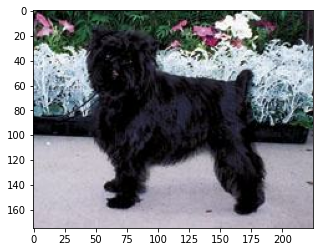

In [67]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [68]:
# 모델, item(이미지 dataset) 입력 -> cam_img 줄력
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

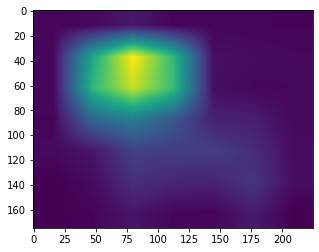

In [69]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [70]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

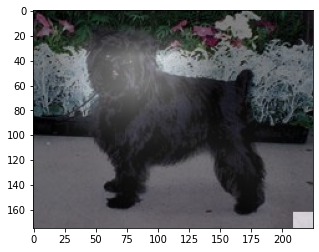

In [71]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.5)
plt.imshow(blended_image)
plt.show()

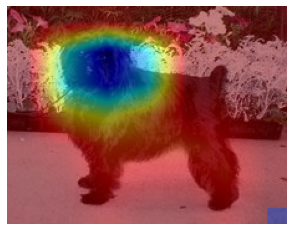

In [72]:
import cv2
cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용

# 원본 이미지와 CAM을 합성
blended_image = visualize_cam_on_image(cam_colored, origin_image, alpha=0.5)

plt.imshow(blended_image)
plt.axis("off")  # 축 숨기기
plt.show()

In [73]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

def show_origin_cam_blend_img(model, img, alpha=0.5):
    item = img
    
    # 원본 이미지 변환
    origin_image = item['image'].astype(np.uint8)
    
    # cam image 생성
    cam_image = generate_cam(cam_model, item)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용

    # 원본 이미지와 CAM을 합성
    blended_image = visualize_cam_on_image(cam_colored, origin_image, alpha=0.5)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(131)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(cam_image_3channel)
    plt.title("CAM Heatmap")
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(blended_image)
    plt.title("Overlay Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

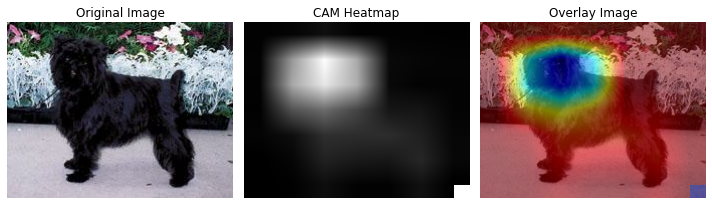

In [74]:
show_origin_cam_blend_img(cam_model, item)

### IOU 도출

In [75]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [76]:
rect = get_bbox(cam_image)
rect

array([[-16,  49],
       [ 97, -37],
       [230, 138],
       [116, 225]])

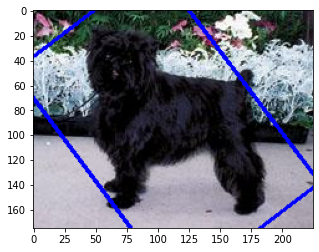

In [77]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [78]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [79]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.21142857142857144,
 -0.07111111111111111,
 1.2857142857142858,
 1.0222222222222221]

In [80]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [81]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [82]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35846832702000525

In [181]:
# 일반적으로 0.5를 기준으로 판단한다고 한다.
# 0.358은 0.5보다 작으므로 오브젝트 디텍션에 Task에 있어 좋지 않은 성능을 뜻한다.
# 오른쪽 아래 하얀색 부분을 보면 잘못 디텍팅 된것을 확인할 수 있는데, 아마도 이때문일것이라고 추측한다.

In [ ]:
# 생각해보니.. cam을 통해 생성한 bbox가 대각선인데, 이렇게 되면 IOU 계산방법이 달라져야 할것 같다...픽셀 단위에서 고려해야 하나 찾아보자

# CAM과 Grad-CAM의 비교 - 근데 이제 오브젝트 사이즈를 고려한

In [84]:
# 다양한 object size 생성하기

11
(332, 500, 3)


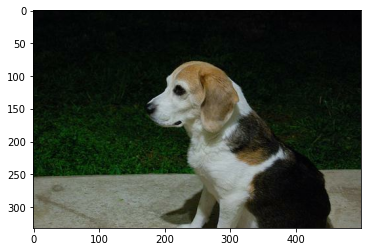

In [177]:
item = get_one(ds_test)
print(item['label'])
print(item['image'].shape)
plt.imshow(item['image'])
plt.show()

In [159]:
# 이미지 크기를 제일 큰것으로 고르려고 했으나 고만고만하다.

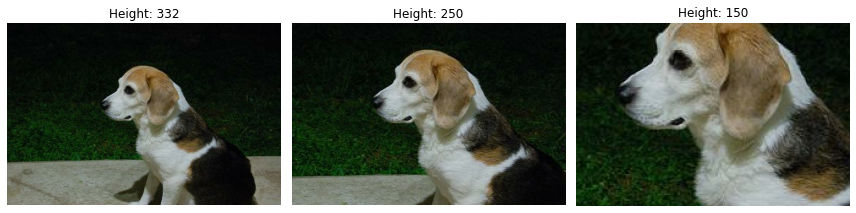

In [224]:
def center_crop(image, new_height):
    """이미지를 주어진 높이로 중앙에서 크롭"""
    h, w, _ = image.shape  # 원본 이미지 크기
    aspect_ratio = w / h   # 가로/세로 비율
    
    # 새로운 크기의 가로 길이 계산 (비율 유지)
    new_width = int(new_height * aspect_ratio)
    
    # 중앙 좌표
    center_x, center_y = w // 2, h // 2
    
    # 크롭할 영역 계산
    half_h, half_w = new_height // 2, new_width // 2
    
    # 중앙 크롭 (이미지 배열 범위를 넘어가지 않도록 보정)
    cropped = image[max(center_y - half_h, 0):min(center_y + half_h, h),
                    max(center_x - half_w, 0):min(center_x + half_w, w)]
    
    return cropped

# 원본 이미지 로드
original_image = item['image']

# 크롭할 세로 길이 리스트
crop_heights = [332, 250, 150]

# 크롭한 이미지 리스트 생성
cropped_images = [center_crop(original_image, h) for h in crop_heights]

# 4개 이미지 출력
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for ax, img, h in zip(axes, cropped_images, crop_heights):
    ax.imshow(img)
    ax.set_title(f"Height: {h}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [225]:
cropped_images[2].shape

(150, 224, 3)

In [226]:
def normalize_and_resize_img2(image):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image

In [221]:
# cropped_images = list(map(normalize_and_resize_img2, cropped_images))
# cropped_images[0].shape

TensorShape([224, 224, 3])

In [233]:
def generate_cam2(model, img, class_idx=item['label']):
    img = copy.deepcopy(img)
    width = img.shape[1]
    height = img.shape[0]
    
    img_tensor = normalize_and_resize_img2(img)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

def show_origin_cam_blend_img2(model, img, alpha=0.5):
    
    # 원본 이미지 변환
    origin_image = img.astype(np.uint8)
    
    # cam image 생성
    cam_image = generate_cam2(model, img, class_idx=item['label'])
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용

    # 원본 이미지와 CAM을 합성
    print(f'이미지 사이즈: {origin_image.shape}')
    blended_image = visualize_cam_on_image(cam_colored, origin_image, alpha=0.5)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(131)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(cam_image_3channel)
    plt.title("CAM Heatmap")
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(blended_image)
    plt.title("Overlay Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

이미지 사이즈: (332, 500, 3)


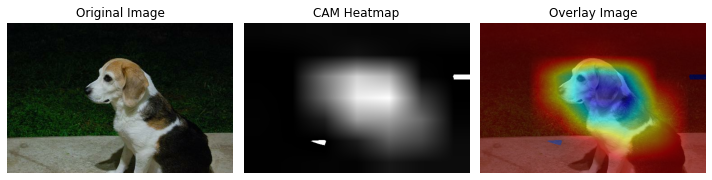

이미지 사이즈: (250, 376, 3)


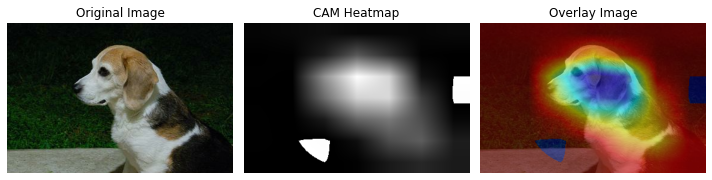

이미지 사이즈: (150, 224, 3)


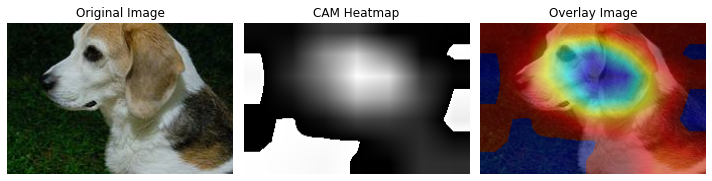

In [242]:
show_origin_cam_blend_img2(cam_model, cropped_images[0])
show_origin_cam_blend_img2(cam_model, cropped_images[1])
show_origin_cam_blend_img2(cam_model, cropped_images[2])

In [235]:
# 이미지 사이즈가 제일 큰(원본사이즈, 332)는 디텍션이 강아지를 조금 벗어난 부분이 있다.
# 250 사이즈는 가장 적절한 디텍션 같다.
# 150 사이즈는 강아지의 너무 일부분만 활성화 되어있고, 주변에 강아지가 전혀 아닌 부분도 활성화 되어있다.

In [248]:
def generate_grad_cam2(model, activation_layer, img, class_idx=item['label']):
    img = copy.deepcopy(img)
    width = img.shape[1]
    height = img.shape[0]
    img_tensor = normalize_and_resize_img2(img)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

def show_origin_gradcam_blend_img2(model, activation_layer, img, alpha=0.5):
    
    # 원본 이미지 변환
    origin_image = img.astype(np.uint8)
    
    # cam image 생성
    cam_image = generate_grad_cam2(model, activation_layer, img, class_idx=item['label'])
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용

    # 원본 이미지와 CAM을 합성
    print(f'이미지 사이즈: {origin_image.shape}')
    print(f'피쳐맵 레이어: {activation_layer}')
    blended_image = visualize_cam_on_image(cam_colored, origin_image, alpha=0.5)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(131)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(cam_image_3channel)
    plt.title("CAM Heatmap")
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(blended_image)
    plt.title("Overlay Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [238]:
cam_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

이미지 사이즈: (332, 500, 3)
피쳐맵 레이어: conv5_block3_out


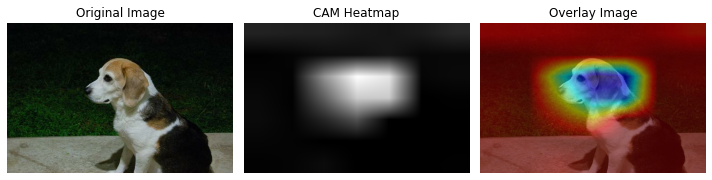

이미지 사이즈: (332, 500, 3)
피쳐맵 레이어: conv4_block6_out


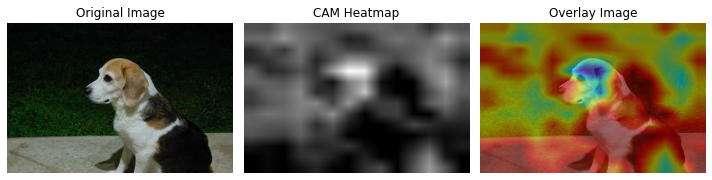

이미지 사이즈: (332, 500, 3)
피쳐맵 레이어: conv3_block4_out


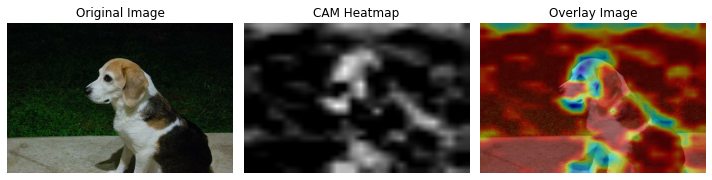

이미지 사이즈: (332, 500, 3)
피쳐맵 레이어: conv2_block3_out


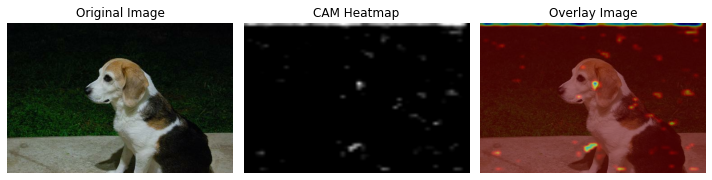

In [249]:
show_origin_gradcam_blend_img2(cam_model, 'conv5_block3_out', cropped_images[0], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv4_block6_out', cropped_images[0], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv3_block4_out', cropped_images[0], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv2_block3_out', cropped_images[0], alpha=0.5)

이미지 사이즈: (250, 376, 3)
피쳐맵 레이어: conv5_block3_out


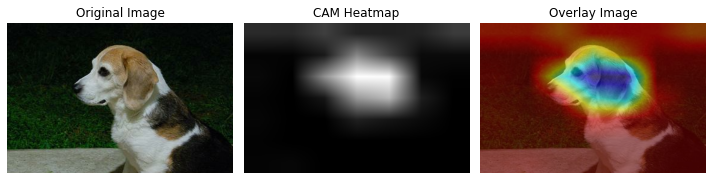

이미지 사이즈: (250, 376, 3)
피쳐맵 레이어: conv4_block6_out


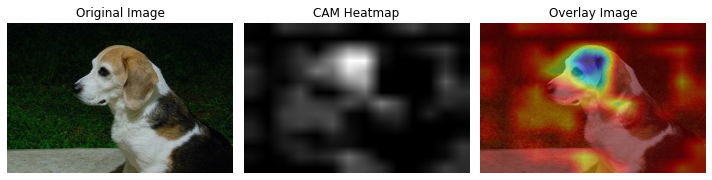

이미지 사이즈: (250, 376, 3)
피쳐맵 레이어: conv3_block4_out


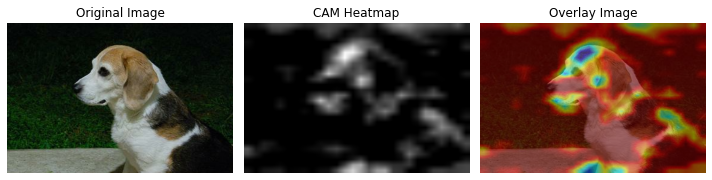

이미지 사이즈: (250, 376, 3)
피쳐맵 레이어: conv2_block3_out


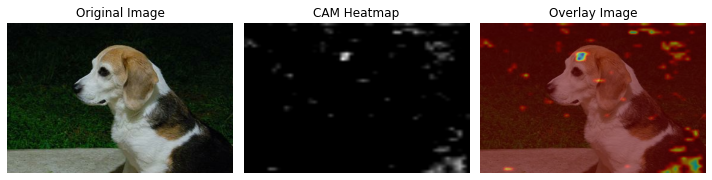

In [250]:
show_origin_gradcam_blend_img2(cam_model, 'conv5_block3_out', cropped_images[1], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv4_block6_out', cropped_images[1], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv3_block4_out', cropped_images[1], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv2_block3_out', cropped_images[1], alpha=0.5)

이미지 사이즈: (150, 224, 3)
피쳐맵 레이어: conv5_block3_out


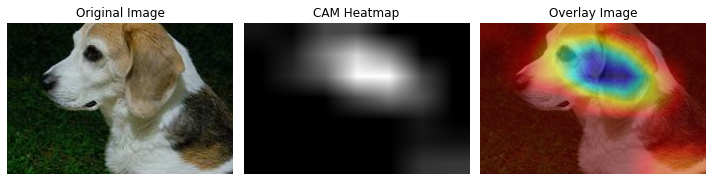

이미지 사이즈: (150, 224, 3)
피쳐맵 레이어: conv4_block6_out


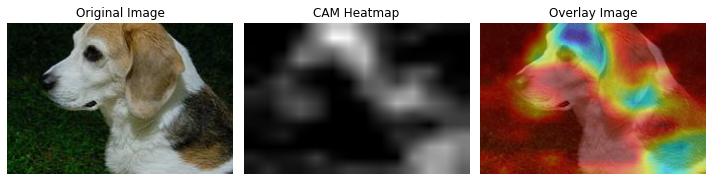

이미지 사이즈: (150, 224, 3)
피쳐맵 레이어: conv3_block4_out


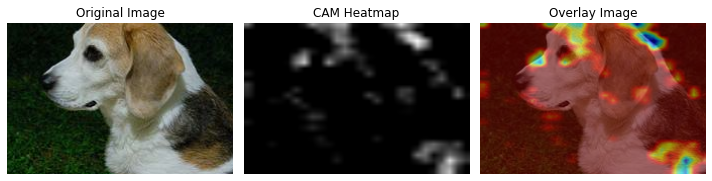

이미지 사이즈: (150, 224, 3)
피쳐맵 레이어: conv2_block3_out


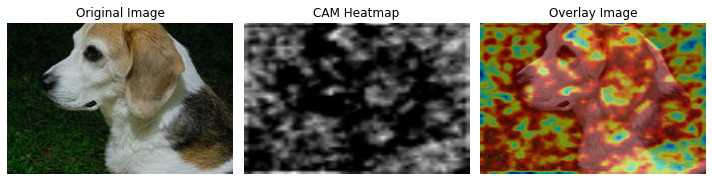

In [251]:
show_origin_gradcam_blend_img2(cam_model, 'conv5_block3_out', cropped_images[2], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv4_block6_out', cropped_images[2], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv3_block4_out', cropped_images[2], alpha=0.5)
show_origin_gradcam_blend_img2(cam_model, 'conv2_block3_out', cropped_images[2], alpha=0.5)

In [252]:
# 오브젝트 사이즈에 따라 적합한 피쳐맵을 찾는 것이 중요하다.
# 332사이즈의 경우 conv3_block4_out가 적절해보인다.
# 250사이즈의 경우 conv4_block6_out가 적절해보인다.
# 150사이즈의 경우 conv4_block6_out가 적절해보인다.
# 오브젝트의 크기가 작을수록 CNN 깊이를 줄이는것이 바람직하다? 라는 결론이 나온다.
# 깊이를 줄이고 width를 넓혀야 한다? 라는 결론이 나온다.

In [253]:
# 지금은 정성적으로 평가했지만, 정량적으로 평가하기 위해서는 IOU를 적용해보면 된다.
# 하지만 시간관계상 pass.(우리에겐 내일도 있으니깐...ㅠ)

# IOU를 정확하게 계산해보자.

In [3]:
# 학습된 모델 불러오기
cam_model_path = './cam_best_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
cam_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
# 샘플 하나 추출
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


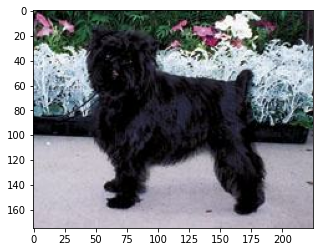

In [6]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

def show_origin_cam_blend_img(model, img, alpha=0.5):
    item = img
    
    # 원본 이미지 변환
    origin_image = item['image'].astype(np.uint8)
    
    # cam image 생성
    cam_image = generate_cam(cam_model, item)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
    cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용

    # 원본 이미지와 CAM을 합성
    blended_image = visualize_cam_on_image(cam_colored, origin_image, alpha=0.5)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(131)
    plt.imshow(origin_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(132)
    plt.imshow(cam_image_3channel)
    plt.title("CAM Heatmap")
    plt.axis("off")
    
    plt.subplot(133)
    plt.imshow(blended_image)
    plt.title("Overlay Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

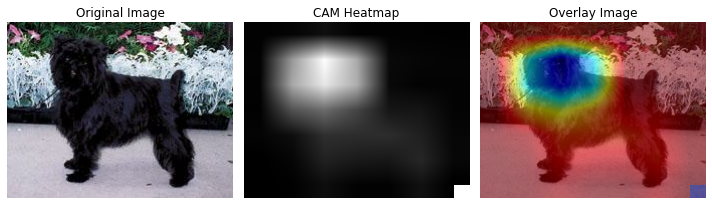

In [8]:
show_origin_cam_blend_img(cam_model, item)

In [9]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

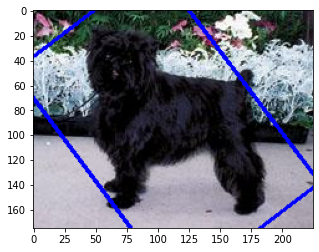

In [10]:
cam_image = generate_cam(cam_model, item)

rect = get_bbox(cam_image)

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [11]:
rect

array([[-16,  49],
       [ 97, -37],
       [230, 138],
       [116, 225]])

In [12]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [13]:
# 이미지 크기
height, width, _ = image.shape

# 정규화된 bbox 좌표 가져오기
bbox = item['objects']['bbox']  # [[x_min, y_min, x_max, y_max]] 형태

# 정규화된 좌표를 원본 이미지 크기로 변환
x_min, y_min, x_max, y_max = bbox[0]  # numpy 배열에서 가져오기
x_min, x_max = int(x_min * width), int(x_max * width)
y_min, y_max = int(y_min * height), int(y_max * height)

# 사각형 좌표 정의
true_bbox = np.array([
    [x_min, y_min],
    [x_max, y_min],
    [x_max, y_max],
    [x_min, y_max]
], dtype=np.int32)

# 리스트의 리스트 형태로 변환
true_bbox = [true_bbox]
true_bbox

[array([[ 17,  28],
        [213,  28],
        [213, 146],
        [ 17, 146]], dtype=int32)]

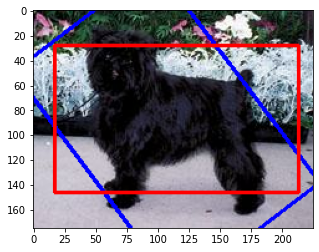

In [14]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = cv2.drawContours(image, true_bbox, 0, (255,0,0), 2)
plt.imshow(image)
plt.show()

In [15]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [65]:
def calculate_rotated_iou(box1, box2):
    """
    두 개의 기울어진 박스(Rotated BBoxes)의 IOU를 계산
    :param box1: 첫 번째 박스 (numpy array, shape=(4,2))
    :param box2: 두 번째 박스 (numpy array, shape=(4,2))
    :return: IoU 값
    """
    # OpenCV의 intersectConvexConvex()를 사용하여 교집합 다각형 찾기
    intersection_pts = cv2.intersectConvexConvex(box1, box2)[1]
    
    if intersection_pts is None:  # 교집합이 없을 경우 IOU는 0
        return 0.0

    # 교집합 영역 면적 계산
    intersection_area = cv2.contourArea(intersection_pts)

    # 두 박스의 개별 면적 계산
    area1 = cv2.contourArea(box1)
    area2 = cv2.contourArea(box2)

    # 합집합 면적 계산
    union_area = area1 + area2 - intersection_area

    # IOU 계산
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

# 기울어진 박스 좌표 (파란색)
rotated_box = np.array(rect, dtype=np.int32)  # 예제: rect가 기울어진 박스

# 일반 사각형 박스 좌표 (빨간색)
true_bbox = np.array(true_bbox[0], dtype=np.int32)  # 정사각형 박스

# IOU 계산
iou_value = calculate_rotated_iou(rotated_box, true_bbox)
print(f"Rotated IOU: {iou_value:.4f}")


Rotated IOU: 0.5419


In [66]:
# 역시 내 예상이 맞았다.(기존 0.3 정도) 0.5 이상이므로 디텍션이 바람직하다고 볼 수 있다.

# 활성화 맵 클리핑(0~255)

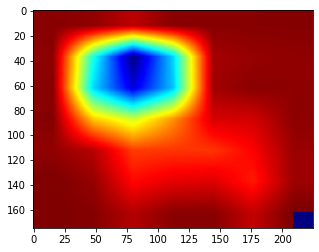

In [14]:
cam_image = generate_cam(cam_model, item)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용
plt.imshow(cam_colored)
plt.show()

In [20]:
np.min(cam_colored.flatten()), np.max(cam_colored.flatten())

(0, 255)

In [22]:
# 어라?.. 이러면 안되는데?... 그러면 우측 하단의 저 파란색은 음수때문이 아니라 실제 높은 값인가?...
# 모델이 잘못된 부분을 보고 있는건가?...

In [23]:
cam_image

array([[ 0.008109  ,  0.008109  ,  0.008109  , ...,  0.00656251,
         0.00656251,  0.00656251],
       [ 0.008109  ,  0.008109  ,  0.008109  , ...,  0.00656251,
         0.00656251,  0.00656251],
       [ 0.008109  ,  0.008109  ,  0.008109  , ...,  0.00656251,
         0.00656251,  0.00656251],
       ...,
       [ 0.00051443,  0.00051443,  0.00051443, ..., -0.00450453,
        -0.00450453, -0.00450453],
       [ 0.00051443,  0.00051443,  0.00051443, ..., -0.00450453,
        -0.00450453, -0.00450453],
       [ 0.00051443,  0.00051443,  0.00051443, ..., -0.00450453,
        -0.00450453, -0.00450453]], dtype=float32)

In [24]:
# cam 은 음수값이 존재하긴 한다. 아마 그 값이 너무 작아서 정수로 바꿀 경우 0으로 되는것으로 추측한다. -> 이는 잘못된 추측

In [25]:
np.min(cam_image.flatten()), np.max(cam_image.flatten())

(-0.004504527, 0.9985309)

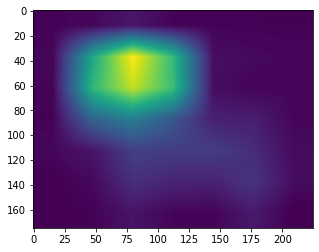

In [16]:
cam_image = generate_cam(cam_model, item)
clipped_cam_image = np.clip(cam_image, 0, 255)

plt.imshow(clipped_cam_image)
plt.show()

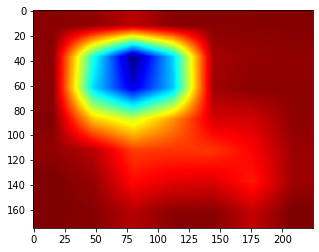

In [17]:
cam_image_3channel = np.stack([clipped_cam_image*255]*3, axis=-1).astype(np.uint8)
cam_colored = cv2.applyColorMap(cam_image_3channel, cv2.COLORMAP_JET)  # 컬러맵 적용
plt.imshow(cam_colored)
plt.show()

In [ ]:
# 위 추측은 잘못되었다. 음수값을 0으로 바꿔주니 해결되었다.